In [1]:
%pwd

'/local/workspace/hailo_virtualenv/lib/python3.10/site-packages/hailo_tutorials/notebooks'

# Parse the model from ONNX to HAR

Initialize a ClientRunner and use the translate_onnx_model method. 

Arguments:

* model_path
* model_name to use
* start_node_names (list of str, optional): Name of the first ONNX node to parse.
* end_node_names (list of str, optional): List of ONNX nodes, that the parsing can stop after all of them are parsed.
* net_input_shapes (dict, optional): A dictionary describing the input shapes for each of the start nodes given in start_node_names, where the keys are the names of the start nodes and the values are their corresponding input shapes. Use only when the original model has dynamic input shapes (described with a wildcard
denoting each dynamic axis, e.g. [b, c, h, w]). 

As a suggestion try translating the ONNX model without supplying the optional arguments.

In [2]:
import tensorflow as tf
from IPython.display import SVG
from hailo_sdk_client import ClientRunner

chosen_hw_arch = "hailo8l"
onnx_model_name = "yolov5m_vehicles"
onnx_path = f"./models/{onnx_model_name}/{onnx_model_name}.onnx"
calib_images_path = f"./models/{onnx_model_name}/{onnx_model_name}_dataset/"

runner = ClientRunner(hw_arch=chosen_hw_arch)
hn, npz = runner.translate_onnx_model(
    onnx_path,
    onnx_model_name
)

[info] Translation started on ONNX model yolov5m_vehicles
[info] Restored ONNX model yolov5m_vehicles (completion time: 00:00:00.34)
[info] Extracted ONNXRuntime meta-data for Hailo model (completion time: 00:00:02.49)
[info] NMS structure of yolov5 (or equivalent architecture) was detected. Default values of NMS anchors were loaded to NMS config json
[info] Start nodes mapped from original model: 'images': 'yolov5m_vehicles/input_layer1'.
[info] End nodes mapped from original model: 'Transpose_272', 'Transpose_288', 'Transpose_304'.
[info] Translation completed on ONNX model yolov5m_vehicles (completion time: 00:00:03.90)


## Generate Hailo Archive

Hailo Archive is a tar.gz archive file that captures the "state" of the model - the files and attributes used in a given stage from parsing to compilation.
Use the `save_har` method to save the runner's state in any stage and `load_har` method to load a saved state to an uninitialized runner.

The initial HAR file includes:
- HN file, which is a JSON-like representation of the graph structure that is deployed to the Hailo hardware.
- NPZ file, which includes the weights of the model.

In [3]:
hailo_model_har_name = f"{onnx_model_name}_hailo_model.har"
runner.save_har(hailo_model_har_name)

[info] Saved HAR to: /local/workspace/hailo_virtualenv/lib/python3.10/site-packages/hailo_tutorials/notebooks/yolov5m_vehicles_hailo_model.har


### Visualize the graph with Hailo’s visualizer tool

[info] Current Time: 00:35:55, 07/04/25
[info] CPU: Architecture: x86_64, Model: 12th Gen Intel(R) Core(TM) i7-12700H, Number Of Cores: 20, Utilization: 1.1%
[info] Memory: Total: 15GB, Available: 3GB
[info] System info: OS: Linux, Kernel: 6.8.0-60-generic
[info] Hailo DFC Version: 3.30.0
[info] HailoRT Version: 4.20.0
[info] PCIe: No Hailo PCIe device was found
[info] Running `hailo visualizer yolov5m_vehicles_hailo_model.har --no-browser`


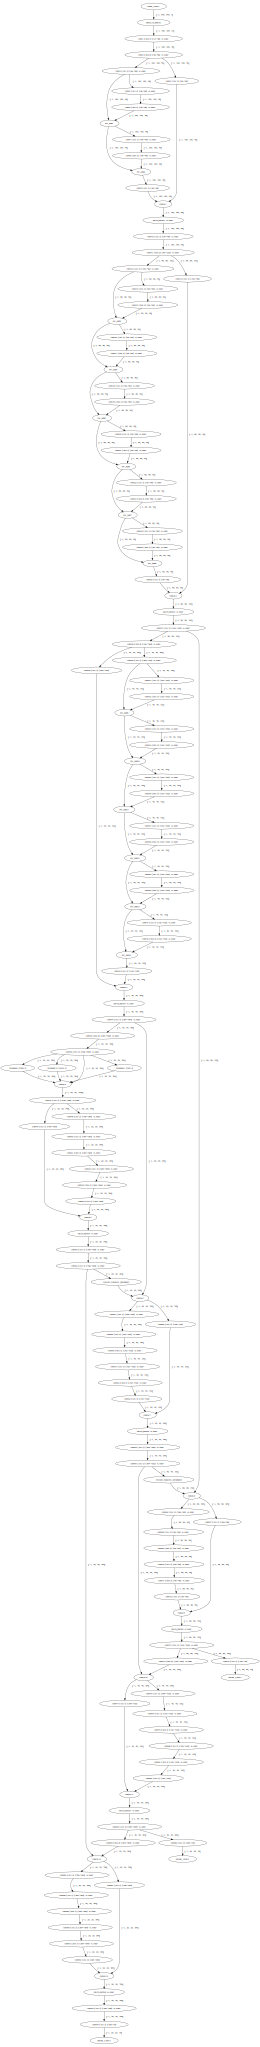

In [4]:
!hailo visualizer {hailo_model_har_name} --no-browser
SVG(f"{onnx_model_name}.svg")

# Model Optimization

After the HAR file has been created (using either runner.translate_tf_model or runner.translate_onnx_model), the next step is to go through the optimization process.

The basic optimization is performed just by calling runner.optimize(calib_dataset. The calibration dataset should be preprocessed according to the model's input requirements and it is recommended to have at least 1024 inputs and to use a GPU. During this step it is also possible to use a model script which change the default behavior of the Dataflow Compiler, for example, to add additional layer for normalization.

In [5]:
import json
import os

import numpy as np
import tensorflow as tf
from IPython.display import SVG
from matplotlib import patches
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow.python.eager.context import eager_mode

from hailo_sdk_client import ClientRunner, InferenceContext

%matplotlib inline

IMAGES_TO_VISUALIZE = 5

model_input_width=640
model_output_height=640
resize_side = int(min(model_input_width, model_output_height) * 1.12)

In [6]:
def preproc(image, output_height=model_output_height, output_width=model_input_width, resize_side=resize_side):
    with eager_mode():
        h, w = image.shape[0], image.shape[1]
        scale = tf.cond(tf.less(h, w), lambda: resize_side / h, lambda: resize_side / w)
        resized_image = tf.compat.v1.image.resize_bilinear(tf.expand_dims(image, 0), [int(h * scale), int(w * scale)])
        cropped_image = tf.compat.v1.image.resize_with_crop_or_pad(resized_image, output_height, output_width)

        return tf.squeeze(cropped_image)


images_path = calib_images_path
images_list = [img_name for img_name in os.listdir(images_path) if os.path.splitext(img_name)[1] == ".jpg"]

print(len(images_list))

calib_dataset = np.zeros((len(images_list), model_output_height, model_input_width, 3))
for idx, img_name in enumerate(sorted(images_list)):
    img = np.array(Image.open(os.path.join(images_path, img_name)).convert('RGB'))
    img_preproc = preproc(img)
    calib_dataset[idx, :, :, :] = img_preproc.numpy()

np.save("calib_set.npy", calib_dataset)

507


### Load the parsed HAR

In [7]:
model_name = onnx_model_name
hailo_model_har_name = f"{model_name}_hailo_model.har"
assert os.path.isfile(hailo_model_har_name), "Please provide valid path for HAR file"
runner = ClientRunner(har=hailo_model_har_name)

### Create a model script

In [8]:
from hailo_sdk_common.hailo_nn.hn_definitions import NMSMetaArchitectures

print("Available meta archs for NMS:")
for arch in NMSMetaArchitectures:
    print(f"- {arch.value}")

Available meta archs for NMS:
- ssd
- centernet
- yolov5
- yolox
- yolov5_seg
- yolov6
- yolov8
- damoyolo


In [9]:
model_script_commands = [
    "normalization1 = normalization([0.0, 0.0, 0.0], [255.0, 255.0, 255.0])\n",
    "resize_input1= resize(resize_shapes=[640,640])\n",
    "nms_postprocess(meta_arch=yolov5, engine=cpu, nms_scores_th=0.2, nms_iou_th=0.4)\n",
]

runner.load_model_script("".join(model_script_commands))

# Call Optimize to perform the optimization process
runner.optimize(calib_dataset)

[info] Loading model script commands to yolov5m_vehicles from string
[info] Using the default score threshold of 0.2 (range is [0-1], where 1 performs maximum suppression) and IoU threshold of 0.4 (range is [0-1], where 0 performs maximum suppression).
Changing the values is possible using the nms_postprocess model script command.
[info] The activation function of layer yolov5m_vehicles/conv75 was replaced by a Sigmoid
[info] The activation function of layer yolov5m_vehicles/conv85 was replaced by a Sigmoid
[info] The activation function of layer yolov5m_vehicles/conv94 was replaced by a Sigmoid
[info] Starting Model Optimization
[warning] Reducing optimization level to 0 (the accuracy won't be optimized and compression won't be used) because there's less data than the recommended amount (1024), and there's no available GPU
[warning] Running model optimization with zero level of optimization is not recommended for production use and might lead to suboptimal accuracy results
[info] Mode

Calibration: 100%|██████████████████████████████████████████████████████████| 64/64 [00:49<00:00,  1.30entries/s]


[info] Model Optimization Algorithm Statistics Collector is done (completion time is 00:00:51.69)
[info] Starting Fix zp_comp Encoding
[info] Model Optimization Algorithm Fix zp_comp Encoding is done (completion time is 00:00:00.00)
[info] Matmul Equalization skipped
[info] Finetune encoding skipped
[info] Bias Correction skipped
[info] Adaround skipped
[info] Quantization-Aware Fine-Tuning skipped
[info] Layer Noise Analysis skipped
[info] Model Optimization is done


### Infer an image with the Hailo Emulator

Inference: 16entries [00:15,  1.06entries/s]


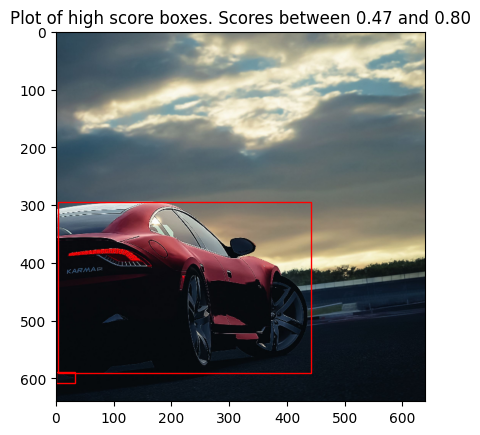

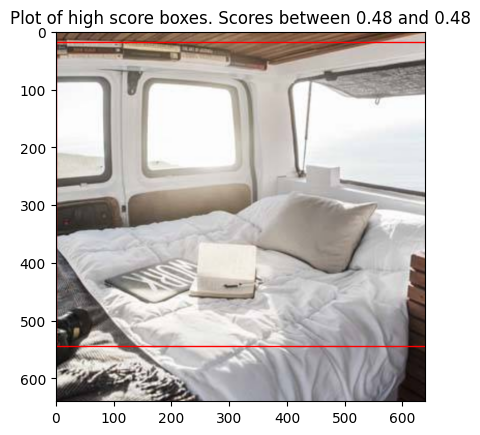

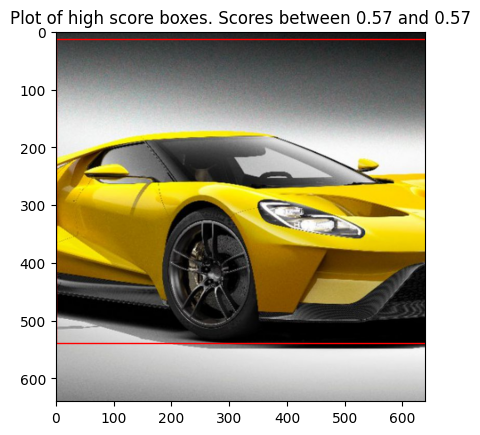

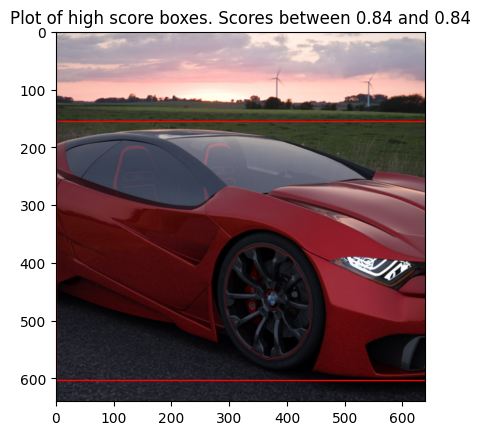

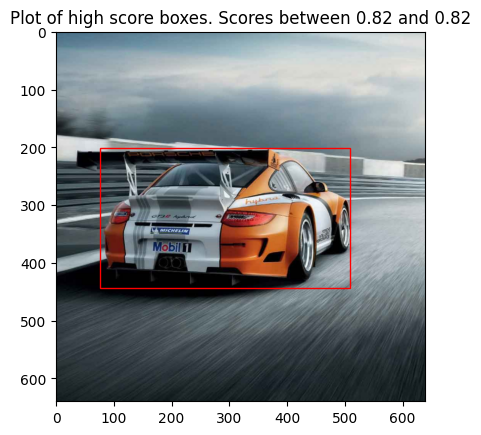

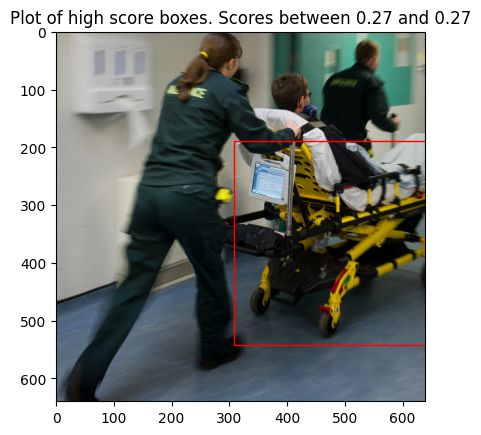

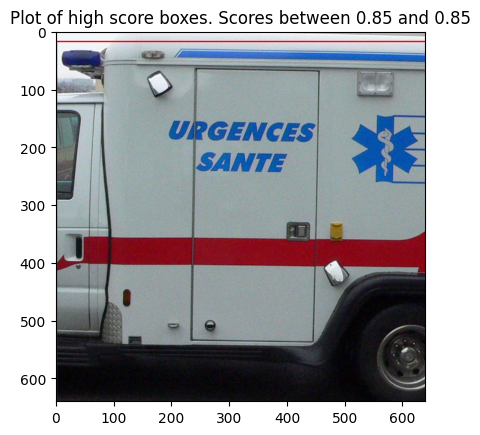

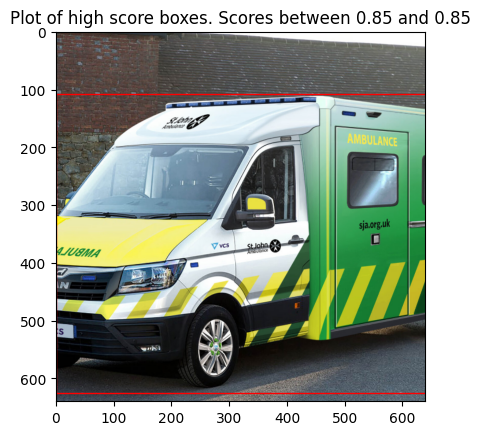

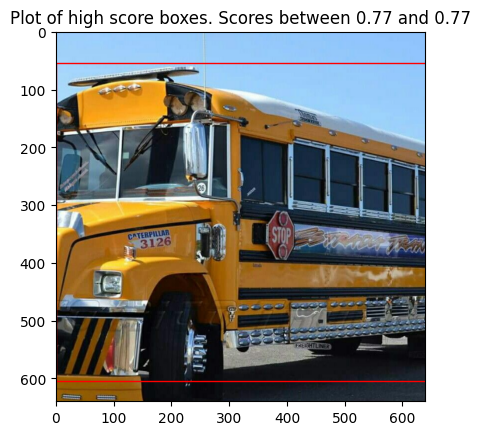

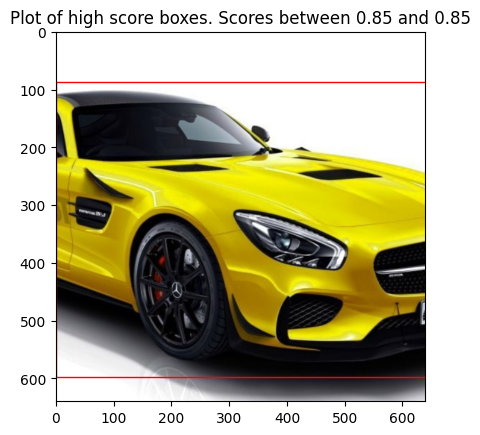

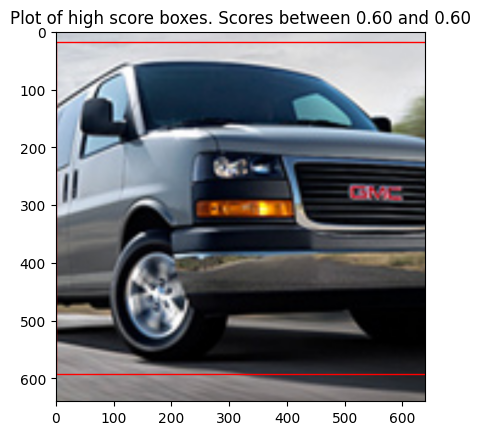

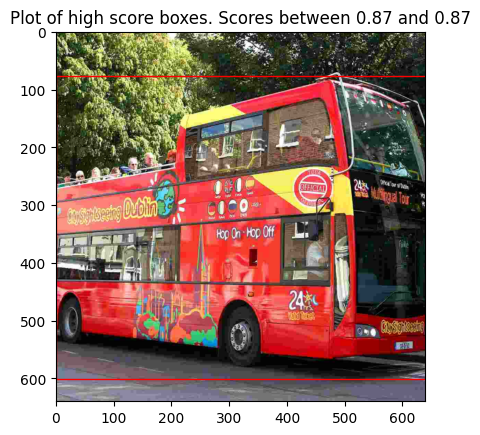

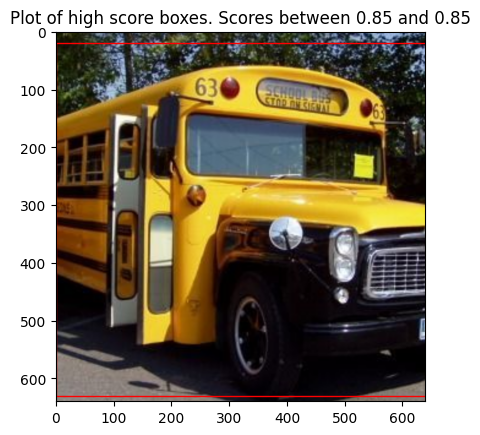

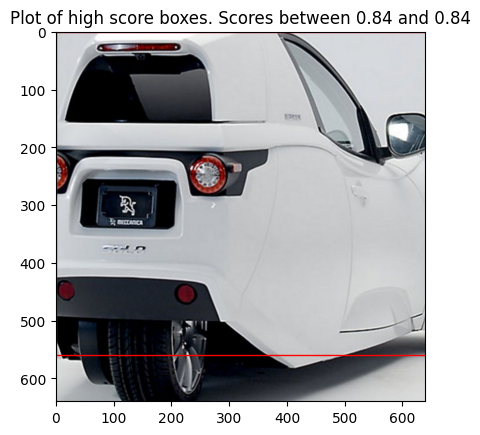

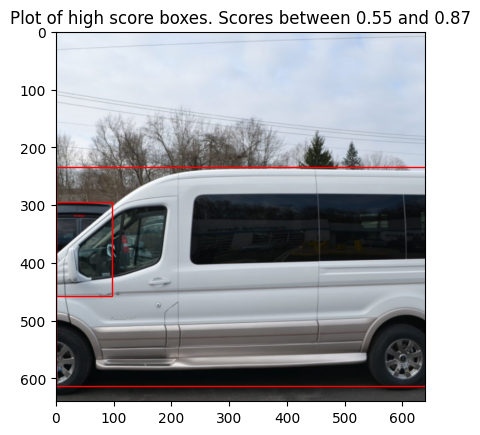

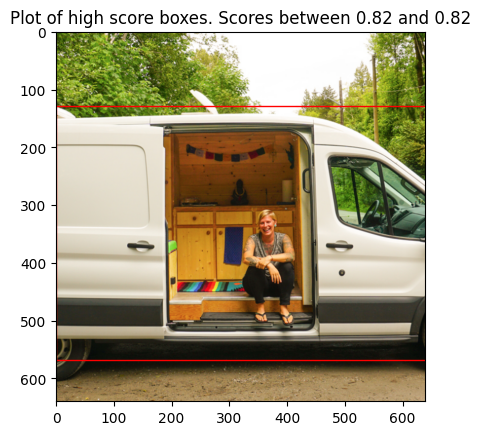

In [10]:
with runner.infer_context(InferenceContext.SDK_FP_OPTIMIZED) as ctx:
    nms_output = runner.infer(ctx, calib_dataset[:16, ...])
HEIGHT = model_input_width
WIDTH = model_input_width
# For each image
for i in range(16):
    found_any = False
    min_score = None
    max_score = None
    # Go over all classes
    for class_index in range(nms_output.shape[1]):
        score, box = nms_output[i][class_index, 4, :], nms_output[i][class_index, 0:4, :]
        # Go over all detections
        for detection_idx in range(box.shape[1]):
            cur_score = score[detection_idx]
            # Discard null detections (because the output tensor is always padded to MAX_DETECTIONS on the emulator interface.
            # Note: On HailoRT APIs (that are used on the Inference Tutorial, and with C++ APIs), the default is a list per class. For more information look for NMS on the HailoRT user guide.
            if cur_score == 0:
                continue

            # Plotting code
            if not found_any:
                found_any = True
                fig, ax = plt.subplots()
                ax.imshow(Image.fromarray(np.array(calib_dataset[i], np.uint8)))
            if min_score is None or cur_score < min_score:
                min_score = cur_score
            if max_score is None or cur_score > max_score:
                max_score = cur_score
            (
                y_min,
                x_min,
            ) = box[0, detection_idx] * HEIGHT, box[1, detection_idx] * WIDTH
            y_max, x_max = box[2, detection_idx] * HEIGHT, box[3, detection_idx] * WIDTH
            center, width, height = (x_min, y_min), x_max - x_min, y_max - y_min
            # draw the box on the input image
            rect = patches.Rectangle(center, width, height, linewidth=1, edgecolor="r", facecolor="none")
            ax.add_patch(rect)

    if found_any:
        plt.title(f"Plot of high score boxes. Scores between {min_score:.2f} and {max_score:.2f}")
        plt.show()

### Save the result state to a Quantized HAR file

In [11]:
quantized_model_har_path = f"{model_name}_quantized_model.har"
runner.save_har(quantized_model_har_path)

[info] Saved HAR to: /local/workspace/hailo_virtualenv/lib/python3.10/site-packages/hailo_tutorials/notebooks/yolov5m_vehicles_quantized_model.har


# Compile the model

Choose the quantized model Hailo Archive file to use, Load the network to the ClientRunner and Run compilation 

In [ ]:
from hailo_sdk_client import ClientRunner

model_name = onnx_model_name
quantized_model_har_path = f"{model_name}_quantized_model.har"

runner = ClientRunner(har=quantized_model_har_path)

hef = runner.compile()

file_name = f"{model_name}.hef"
with open(file_name, "wb") as f:
    f.write(hef)

[info] To achieve optimal performance, set the compiler_optimization_level to "max" by adding performance_param(compiler_optimization_level=max) to the model script. Note that this may increase compilation time.
[info] Loading network parameters
[info] Starting Hailo allocation and compilation flow
[info] Adding an output layer after conv75
[info] Adding an output layer after conv85
[info] Adding an output layer after conv94
[info] Finding the best partition to contexts...
[info] Iteration #1 - Contexts: 4
[info] Iteration #1 - Contexts: 4,
[info] Iteration #2 - Contexts: 4
[info] Iteration #2 - Contexts: 4,
[info] Iteration #3 - Contexts: 4
[info] Iteration #3 - Contexts: 4,
[info] Iteration #4 - Contexts: 4
[info] Iteration #4 - Contexts: 4,
[info] Iteration #5 - Contexts: 4
[info] Iteration #5 - Contexts: 4,
[info] Iteration #6 - Contexts: 4
[info] Iteration #6 - Contexts: 4,
[info] Iteration #7 - Contexts: 4
[info] Iteration #7 - Contexts: 4,
[info] Iteration #8 - Contexts: 4
[info

[info] Iteration #110 - Contexts: 6
[info] Iteration #110 - Contexts: 6,
[info] Iteration #111 - Contexts: 6
[info] Iteration #111 - Contexts: 6,
[info] Iteration #112 - Contexts: 6
[info] Iteration #112 - Contexts: 6,
[info] Iteration #113 - Contexts: 6
[info] Iteration #113 - Contexts: 6,
[info] Iteration #114 - Contexts: 6
[info] Iteration #114 - Contexts: 6,
[info] Iteration #115 - Contexts: 6
[info] Iteration #115 - Contexts: 6,
[info] Iteration #116 - Contexts: 6
[info] Iteration #116 - Contexts: 6,
[info] Iteration #117 - Contexts: 6
[info] Iteration #117 - Contexts: 6,
[info] Iteration #118 - Contexts: 6
[info] Iteration #118 - Contexts: 6,
[info] Iteration #119 - Contexts: 6
[info] Iteration #119 - Contexts: 6,
[info] Iteration #120 - Contexts: 6
[info] Iteration #120 - Contexts: 6,
[info] Iteration #121 - Contexts: 6
[info] Iteration #121 - Contexts: 6,
[info] Iteration #122 - Contexts: 6
[info] Iteration #122 - Contexts: 6,
[info] Iteration #123 - Contexts: 6
[info] Iteratio

[info] Iteration #223 - Contexts: 7
[info] Iteration #223 - Contexts: 7,
[info] Iteration #224 - Contexts: 7
[info] Iteration #224 - Contexts: 7,
[info] Iteration #225 - Contexts: 7
[info] Iteration #225 - Contexts: 7,
[info] Iteration #226 - Contexts: 7
[info] Iteration #226 - Contexts: 7,
[info] Iteration #227 - Contexts: 7
[info] Iteration #227 - Contexts: 7,
[info] Iteration #228 - Contexts: 7
[info] Iteration #228 - Contexts: 7,
[info] Iteration #229 - Contexts: 7
[info] Iteration #229 - Contexts: 7,
[info] Iteration #230 - Contexts: 7
[info] Iteration #230 - Contexts: 7,
[info] Iteration #231 - Contexts: 7
[info] Iteration #231 - Contexts: 7,
[info] Iteration #232 - Contexts: 7
[info] Iteration #232 - Contexts: 7,
[info] Iteration #233 - Contexts: 7
[info] Iteration #233 - Contexts: 7,
[info] Iteration #234 - Contexts: 7
[info] Iteration #234 - Contexts: 7,
[info] Iteration #235 - Contexts: 7
[info] Iteration #235 - Contexts: 7,
[info] Iteration #236 - Contexts: 7
[info] Iteratio

[info] Iteration #336 - Contexts: 9
[info] Iteration #336 - Contexts: 9,
[info] Iteration #337 - Contexts: 9
[info] Iteration #337 - Contexts: 9,
[info] Iteration #338 - Contexts: 9
[info] Iteration #338 - Contexts: 9,
[info] Iteration #339 - Contexts: 9
[info] Iteration #339 - Contexts: 9,
[info] Iteration #340 - Contexts: 9
[info] Iteration #340 - Contexts: 9,
[info] Iteration #341 - Contexts: 9
[info] Iteration #341 - Contexts: 9,
[info] Iteration #342 - Contexts: 9
[info] Iteration #342 - Contexts: 9,
[info] Iteration #343 - Contexts: 9
[info] Iteration #343 - Contexts: 9,
[info] Iteration #344 - Contexts: 9
[info] Iteration #344 - Contexts: 9,
[info] Iteration #345 - Contexts: 9
[info] Iteration #345 - Contexts: 9,
[info] Iteration #346 - Contexts: 9
[info] Iteration #346 - Contexts: 9,
[info] Iteration #347 - Contexts: 9
[info] Iteration #347 - Contexts: 9,
[info] Iteration #348 - Contexts: 9
[info] Iteration #348 - Contexts: 9,
[info] Iteration #349 - Contexts: 9
[info] Iteratio

[info] conv73: Pass
[info] conv71: Pass
[info] conv78: Pass
[info] conv76: Pass
[info] conv77: Pass
[info] context_1_to_context_3_in_7: Pass
[info] conv74: Pass
[info] concat10: Pass
[info] context_3_to_context_4_19: Pass
[info] context_3_to_context_4_21: Pass
[info] context_3_to_context_4_24: Pass
[info] conv75: Pass
[info] context_2_to_context_3_in_15: Pass
[info] conv53_dc: Pass
[info] context_1_to_context_3_in_13: Pass
[info] context_2_to_context_3_in_18: Pass
[info] conv53_d0: Pass
[info] conv53_d1: Pass
[info] output_from_conv85_to_yolov5_nms_postprocess: Pass
[info] output_from_conv94_to_yolov5_nms_postprocess: Pass
[info] concat13: Pass
[info] batch_norm8: Pass
[info] conv94: Pass
[info] concat11: Pass
[info] conv85: Pass
[info] concat12: Pass
[info] conv82: Pass
[info] conv86: Pass
[info] conv89_dc: Pass
[info] conv83: Pass
[info] conv92: Pass
[info] batch_norm7: Pass
[info] conv90: Pass
[info] conv88: Pass
[info] conv80: Pass
[info] conv87: Pass
[info] conv89_d1: Pass
[info] 



[info] Context:1/4 Iteration 0: Trying parallel splits...   
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0                                                                                                  
 worker1                                                                                                  
 worker2                                                                                                  
 worker3                                                                                                  

  00:02
[info] Context:1/4 Iteration 0: Trying parallel splits...   
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0                                                                                                  
 worker1                                                                                                  
 worker2  *

[info] Context:1/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          *          *          V          *          *          V       
 worker1  V          V          *          *          V          V          *          *          V       
 worker2  V          V          *          *          *          V          *          *          V       
 worker3  *          *          *          *          *          V          *          *          V       

  00:02
[info] Context:1/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          *          *          V          *          *          V       
 worker1  V          V          *          *          V          V          *          *          V       
 worker2  V  

[info] Context:2/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1  V          V          *          *          *          V          *          *          V       
 worker2  V          *          *          *          V          V          *          *          V       
 worker3  *          *          *          *          *          *          *          *          V       

  00:06
[info] Context:2/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          *          *          *          *          *          *          *          V       
 worker1  V          V          *          *          *          V          *          *          V       
 worker2  V  

[info] Context:3/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          *          *          V          *          *          V       
 worker1  V          V          *          *          *          V          *          *          V       
 worker2  V          V          *          *          V          V          *          *          V       
 worker3  V          V          *          *          V          V          *          *          V       

  00:12
[info] Context:3/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          *          *          V          *          *          V       
 worker1  V          V          *          *          V          V          *          *          V       
 worker2  V  

[info] Context:4/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          *          *          *          *          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  *          *          *          *          *          V          *          *          V       
 worker3  *          *          *          *          *          *          *          *          V       

  00:14
[info] Context:4/4 Iteration 4: Trying parallel mapping...  
          cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  prepost 
 worker0  *          V          *          *          *          *          *          *          V       
 worker1  *          *          *          *          *          *          *          *          V       
 worker2  *  

[info] Compiling context_1...
[info] Compiling context_2...
[info] Compiling context_3...
[info] Compiling context_4...
[info] Bandwidth of model inputs: 9.375 Mbps, outputs: 1.15356 Mbps (for a single frame)
[info] Bandwidth of DDR buffers: 0.0 Mbps (for a single frame)
[info] Bandwidth of inter context tensors: 77.3438 Mbps (for a single frame)
[info] Compiling context_0...
[info] Compiling context_1...


## Profiler tool

Run the profiler tool:

This command will pop-open the HTML report in the browser.

In [ ]:
har_path = f"{model_name}_compiled_model.har"
runner.save_har(har_path)
!hailo profiler {har_path}